# Exploring Geometric Utilities on SNEMI 2D

This notebook loads a single 2D slice from the SNEMI3D AC4 volume and
visualises five geometric properties used by the discriminative loss:

1. Instance labels
2. Instance boundaries (morphological dilation / erosion)
3. Instance skeletons (distance-transform ridges)
4. Orientation vectors pointing toward centroid vs skeleton
5. Per-instance covariance as tensor glyphs (ellipses)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pathlib import Path
from scipy.ndimage import distance_transform_edt

from neurons.utils.io import find_folder, load_volume
from neurons.utils.labels import relabel_after_crop
from neurons.losses.discriminative import (
    _make_coord_grid,
    _compute_centroid_offsets,
    _compute_covariance,
    _skeletonize_mask,
)

matplotlib.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'cm',
    'font.size': 12,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})

CMAP_LABELS = plt.cm.tab20

%matplotlib inline

## 1. Load SNEMI 2D Slice

Load the AC4 volume and labels, extract slice `z=50`, and crop a
256 x 256 patch for manageable computation and clear visualisation.

In [2]:
DATA_ROOT = Path('../data/snemi3d')

vol_path = find_folder(DATA_ROOT, 'AC4_inputs')
seg_path = find_folder(DATA_ROOT, 'AC4_labels')

volume = load_volume(vol_path)
labels_3d = load_volume(seg_path)

SLICE_IDX = 50
ROW_SLICE = slice(256, 512)
COL_SLICE = slice(256, 512)

img_2d = volume[SLICE_IDX, ROW_SLICE, COL_SLICE]
lbl_crop = labels_3d[SLICE_IDX, ROW_SLICE, COL_SLICE]
lbl_2d = relabel_after_crop(
    torch.from_numpy(lbl_crop.astype(np.int64)), spatial_dims=2,
).numpy()

H, W = lbl_2d.shape
print(f'Crop shape: ({H}, {W})')
print(f'Image dtype={img_2d.dtype}  range=[{img_2d.min()}, {img_2d.max()}]')
print(f'Label dtype={lbl_2d.dtype}  unique={len(np.unique(lbl_2d))}')

device = torch.device('cpu')
lbl_tensor = torch.from_numpy(lbl_2d.astype(np.int64)).to(device)
lbl_flat = lbl_tensor.reshape(-1)
coords = _make_coord_grid((H, W), device)  # [2, N]  (x=col, y=row)

unique_ids = np.unique(lbl_2d)
unique_ids = unique_ids[unique_ids > 0]
print(f'Foreground instances: {len(unique_ids)}')

Crop shape: (256, 256)
Image dtype=uint8  range=[0, 198]
Label dtype=int64  unique=38
Foreground instances: 37


## 2. Instance Labels

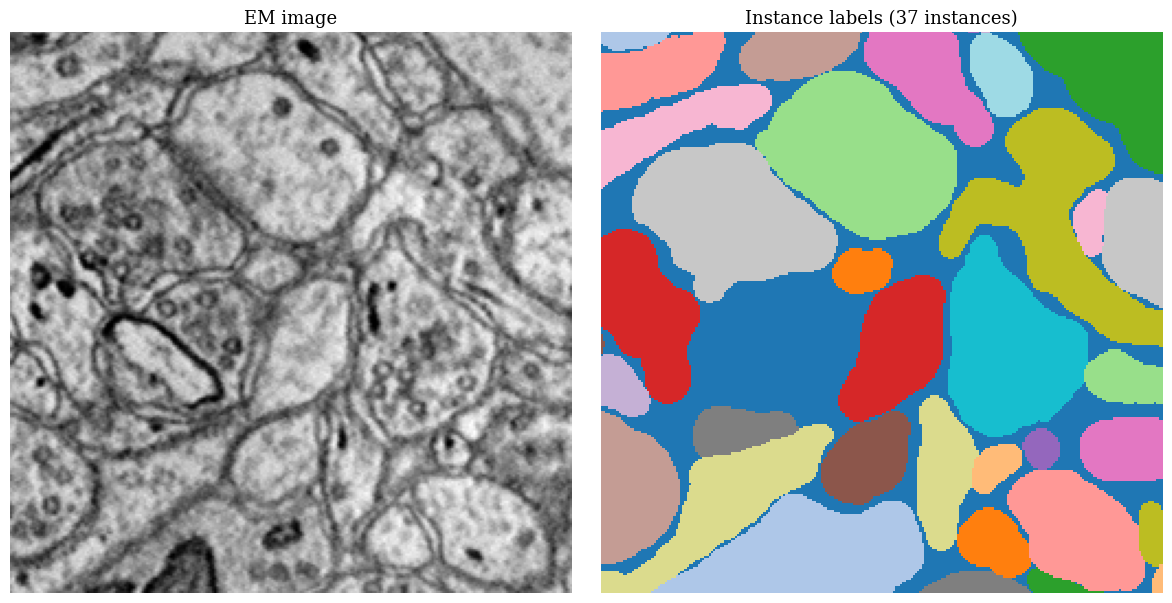

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_2d, cmap='gray', aspect='equal')
axes[0].set_title('EM image')
axes[0].axis('off')

axes[1].imshow(lbl_2d % 20, cmap=CMAP_LABELS, interpolation='nearest', aspect='equal')
axes[1].set_title(f'Instance labels ({len(unique_ids)} instances)')
axes[1].axis('off')

fig.tight_layout()
plt.show()

## 3. Boundary Detection

Instance boundaries are detected with morphological dilation / erosion:
a pixel is on the boundary when `dilated != eroded`.

Boundary pixels: 10323 / 65536  (15.8%)


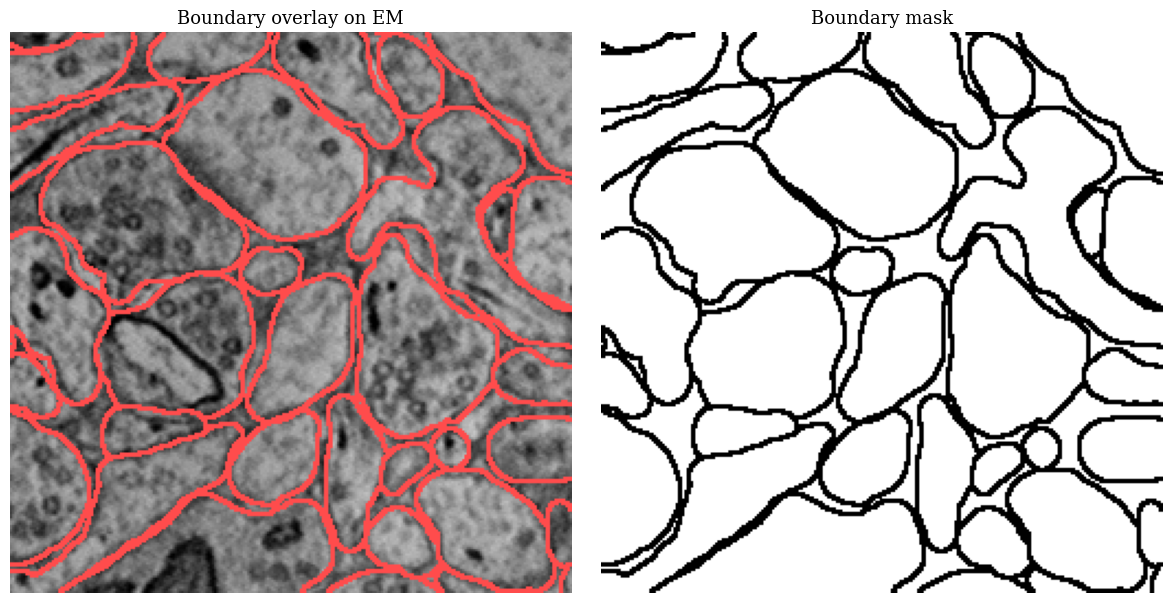

In [4]:
lbl_4d = torch.from_numpy(lbl_2d.astype(np.float32)).unsqueeze(0).unsqueeze(0)
kernel_size = 3
pad = kernel_size // 2

eroded = -F.max_pool2d(-lbl_4d, kernel_size=kernel_size, stride=1, padding=pad)
dilated = F.max_pool2d(lbl_4d, kernel_size=kernel_size, stride=1, padding=pad)
boundary = (dilated != eroded).float().squeeze().numpy()

print(f'Boundary pixels: {int(boundary.sum())} / {H * W}'
      f'  ({100 * boundary.mean():.1f}%)')

overlay_bnd = np.stack([img_2d / 255.0] * 3, axis=-1)
overlay_bnd[boundary > 0] = [1.0, 0.3, 0.3]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(overlay_bnd, aspect='equal')
axes[0].set_title('Boundary overlay on EM')
axes[0].axis('off')

axes[1].imshow(boundary, cmap='gray_r', aspect='equal')
axes[1].set_title('Boundary mask')
axes[1].axis('off')

fig.tight_layout()
plt.show()

## 4. Skeleton Extraction

Per-instance skeletons are extracted with the topology-preserving
iterative boundary-peeling algorithm of Menten et al. (ICCV 2023),
implemented as `Skeletonize` in `neurons.losses.skeletonize`.

Skeleton pixels: 1578 / 65536


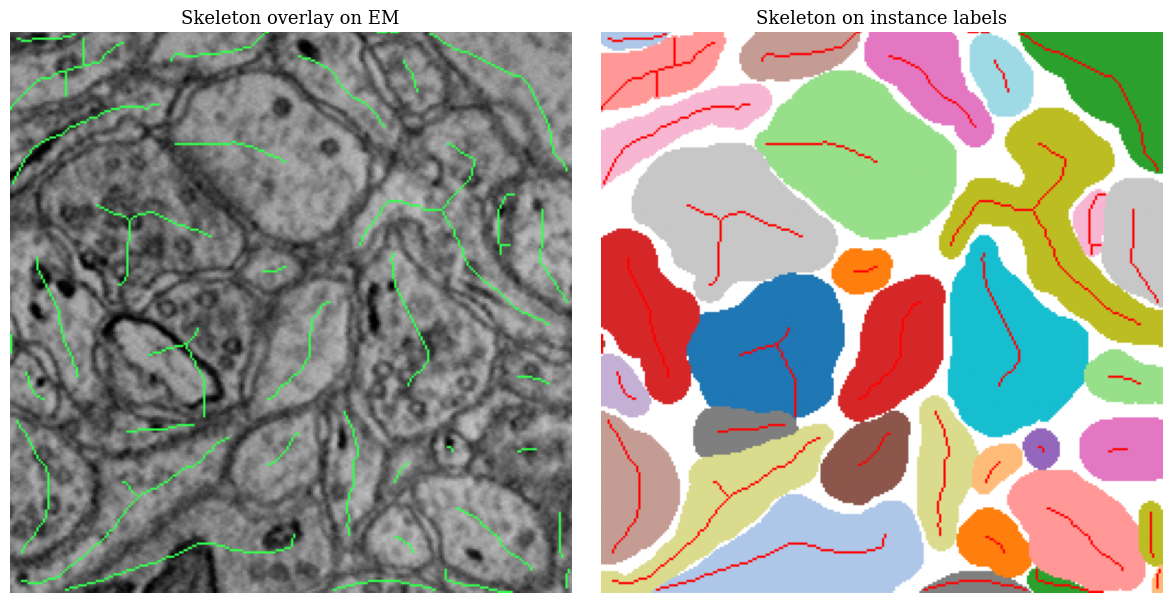

In [5]:
skeleton_mask = np.zeros((H, W), dtype=bool)

for uid in unique_ids:
    inst = lbl_tensor == int(uid)
    if inst.sum() < 2:
        continue
    skel = _skeletonize_mask(inst)
    skeleton_mask |= skel.cpu().numpy()

print(f'Skeleton pixels: {int(skeleton_mask.sum())} / {H * W}')

overlay_skel = np.stack([img_2d / 255.0] * 3, axis=-1)
overlay_skel[skeleton_mask] = [0.2, 1.0, 0.3]

label_rgb = CMAP_LABELS(lbl_2d % 20)[..., :3]
label_rgb[lbl_2d == 0] = 1.0
skel_on_labels = label_rgb.copy()
skel_on_labels[skeleton_mask] = [1.0, 0.0, 0.0]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(overlay_skel, aspect='equal')
axes[0].set_title('Skeleton overlay on EM')
axes[0].axis('off')

axes[1].imshow(skel_on_labels, aspect='equal')
axes[1].set_title('Skeleton on instance labels')
axes[1].axis('off')

fig.tight_layout()
plt.show()

## 5. Orientation Vectors: Centroid vs Skeleton

Per-pixel offset vectors point each foreground pixel toward its instance
centroid (left) or nearest skeleton point (right).  Arrows are
unit-normalised so the plot shows direction only.

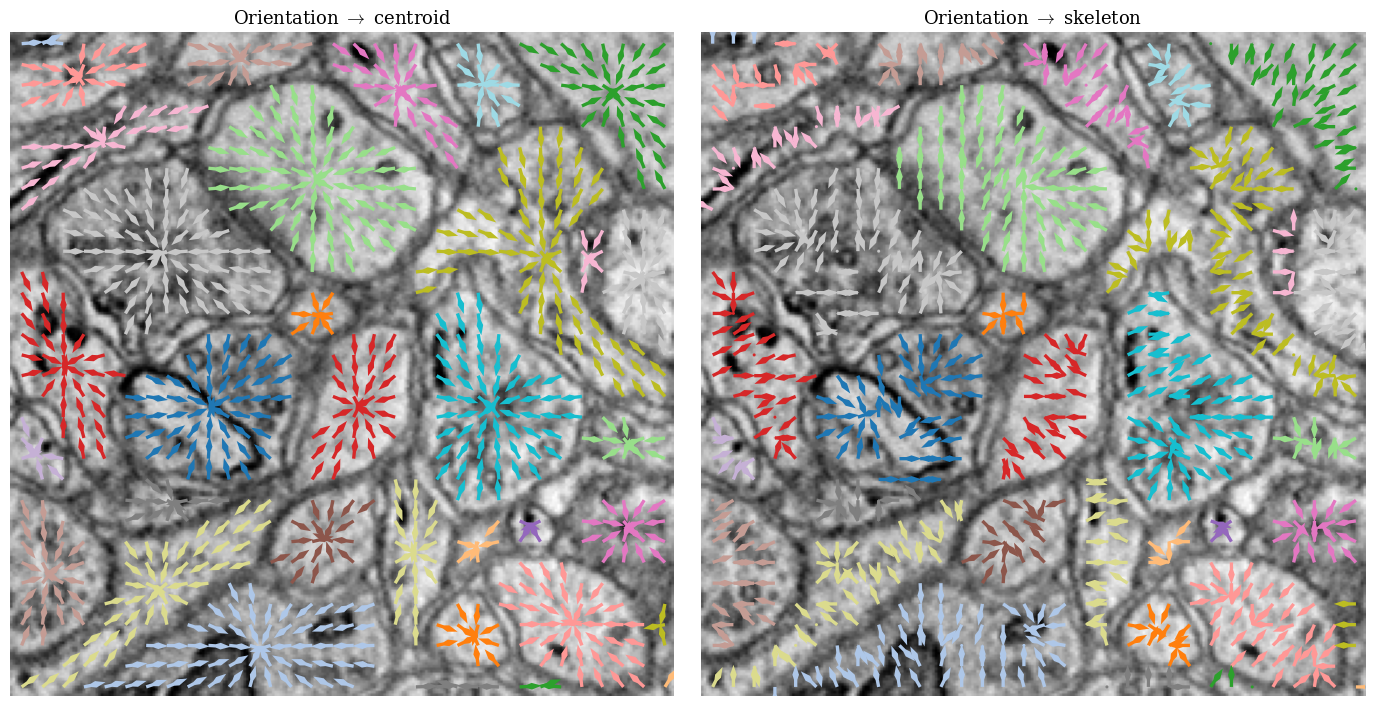

In [6]:
centroid_off = _compute_centroid_offsets(lbl_flat, coords)  # [2, N]
cent_2d = centroid_off.numpy().reshape(2, H, W)

# Per-instance offset toward nearest connected-skeleton point
skel_off_col = np.zeros((H, W), dtype=np.float32)
skel_off_row = np.zeros((H, W), dtype=np.float32)

for uid in unique_ids:
    inst = lbl_2d == uid
    inst_skel = skeleton_mask & inst
    if inst_skel.sum() == 0:
        continue
    _, nearest_idx = distance_transform_edt(~inst_skel, return_indices=True)
    rs, cs = np.where(inst)
    skel_off_row[rs, cs] = nearest_idx[0][rs, cs] - rs
    skel_off_col[rs, cs] = nearest_idx[1][rs, cs] - cs

step = 8
rows_sub = np.arange(step // 2, H, step)
cols_sub = np.arange(step // 2, W, step)
C, R = np.meshgrid(cols_sub, rows_sub)
fg = lbl_2d[R, C] > 0

U_cent = cent_2d[0, R, C]    # dx  (centroid - pixel, col direction)
V_cent = -cent_2d[1, R, C]  # dy  negated: quiver V+ = screen-up, but row+ = screen-down

U_skel = skel_off_col[R, C]
V_skel = -skel_off_row[R, C]

def _unit(U, V, mask):
    mag = np.sqrt(U ** 2 + V ** 2)
    mag = np.where(mask & (mag > 0), mag, 1.0)
    return U / mag, V / mag

U_cent_n, V_cent_n = _unit(U_cent, V_cent, fg)
U_skel_n, V_skel_n = _unit(U_skel, V_skel, fg)

arrow_colors = CMAP_LABELS(lbl_2d[R, C].ravel() % 20)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for ax, U, V, title in [
    (axes[0], U_cent_n, V_cent_n, r'Orientation $\rightarrow$ centroid'),
    (axes[1], U_skel_n, V_skel_n, r'Orientation $\rightarrow$ skeleton'),
]:
    ax.imshow(img_2d, cmap='gray', aspect='equal')
    m = fg.ravel()
    ax.quiver(
        C.ravel()[m], R.ravel()[m],
        U.ravel()[m], V.ravel()[m],
        color=arrow_colors[m],
        scale=30, width=0.005, headwidth=2, headlength=3,
    )
    ax.set_title(title)
    ax.axis('off')

fig.tight_layout()
plt.show()

## 6. Tensor Glyphs: Per-Instance vs Local (EDT Structure Tensor)

**Left** -- one ellipse per instance at its centroid, axes from the global
coordinate covariance (captures overall shape elongation).

**Right** -- ellipses on a subsampled grid from the EDT structure tensor
(smoothed gradient outer-product).  Near boundaries the glyph is
anisotropic (elongated along the boundary tangent); near the medial axis
it becomes isotropic (round).

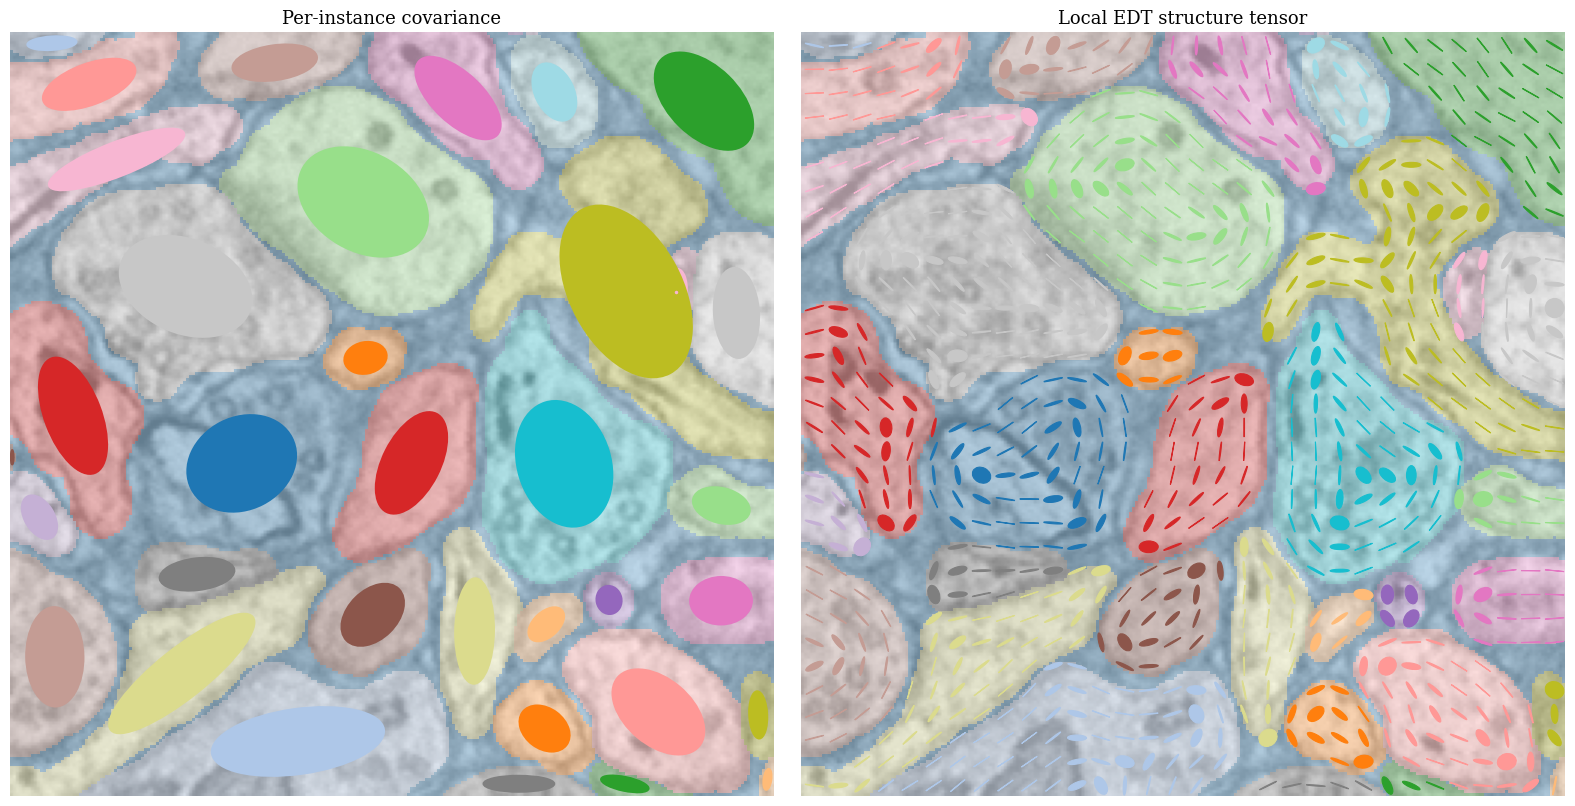

In [9]:
# ---- Left panel: per-instance global covariance ellipse at centroid ----
inst_glyphs = []
for uid in unique_ids:
    mask = lbl_2d == uid
    rows, cols = np.where(mask)
    if len(rows) < 10:
        continue
    cy, cx = rows.mean(), cols.mean()
    pts = np.stack([cols.astype(np.float64), rows.astype(np.float64)])
    mu = pts.mean(axis=1, keepdims=True)
    centered = pts - mu
    cov = (centered @ centered.T) / (pts.shape[1] - 1)
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvals = np.maximum(eigvals, 0.0)
    if eigvals[-1] < 1e-6:
        continue
    angle = np.degrees(np.arctan2(eigvecs[1, -1], eigvecs[0, -1]))
    w = 2.0 * np.sqrt(eigvals[-1])
    h = 2.0 * np.sqrt(eigvals[0])
    inst_glyphs.append((cx, cy, w, h, angle, int(uid)))

# ---- Right panel: per-pixel local structure tensor glyphs ----
st_flat = _compute_covariance(lbl_flat, coords, (H, W))  # [4, N]
st_2d = st_flat.numpy().reshape(2, 2, H, W)

step = 8
glyph_radius = step * 0.4
rows_sub = np.arange(step // 2, H, step)
cols_sub = np.arange(step // 2, W, step)
CC, RR = np.meshgrid(cols_sub, rows_sub)

local_glyphs = []
for ri in range(RR.shape[0]):
    for ci in range(RR.shape[1]):
        r, c = int(RR[ri, ci]), int(CC[ri, ci])
        if lbl_2d[r, c] == 0:
            continue
        T = st_2d[:, :, r, c]
        eigvals, eigvecs = np.linalg.eigh(T)
        abs_eig = np.abs(eigvals)
        idx_max = int(abs_eig.argmax())
        idx_min = 1 - idx_max
        eig_max = abs_eig[idx_max]
        if eig_max < 1e-6:
            continue
        ratio = abs_eig[idx_min] / eig_max
        angle = np.degrees(np.arctan2(
            eigvecs[1, idx_min], eigvecs[0, idx_min]))
        local_glyphs.append((c, r, ratio, angle, int(lbl_2d[r, c])))

# ---- Draw both panels ----
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for ax in axes:
    ax.imshow(img_2d, cmap='gray', aspect='equal', alpha=0.5)
    ax.imshow(lbl_2d % 20, cmap=CMAP_LABELS, interpolation='nearest',
              aspect='equal', alpha=0.3)
    ax.set_xlim(-0.5, W - 0.5)
    ax.set_ylim(H - 0.5, -0.5)
    ax.axis('off')

for cx, cy, w, h, angle, uid in inst_glyphs:
    color = CMAP_LABELS(uid % 20)
    axes[0].add_patch(Ellipse(
        xy=(cx, cy), width=w, height=h, angle=angle,
        fill=True, facecolor=color, edgecolor=color, linewidth=1.5))
    axes[0].plot(cx, cy, '.', color=color, markersize=3)

for cx, cy, ratio, angle, uid in local_glyphs:
    color = CMAP_LABELS(uid % 20)
    axes[1].add_patch(Ellipse(
        xy=(cx, cy),
        width=2 * glyph_radius,
        height=2 * glyph_radius * ratio,
        angle=angle,
        fill=True, facecolor=color, edgecolor=color, linewidth=0.8))

axes[0].set_title('Per-instance covariance')
axes[1].set_title('Local EDT structure tensor')
fig.tight_layout()
plt.show()